In [1]:
from torch.utils.data import random_split, TensorDataset
from torchvision.transforms import functional as f
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("/home/student-1/.local_libs")


In [3]:
from utils.PDOeConv import PDO_eConvs
from utils.PDOeConv import init_weights
import torch.optim as optim
from utils.Train import train, evaluate_accuracy
from sklearn.model_selection import train_test_split

In [4]:
model = PDO_eConvs()

In [5]:
import pickle
load_path = 'data/P4MUPDATED.pkl'
with open(load_path, 'rb') as f:
        data = pickle.load(f)

In [6]:
mnist_data = data['images']
mnist_label = data['labels']

In [7]:
mnist_data.shape

(70000, 28, 28, 1)

In [8]:
np.random.seed(42)
images = torch.tensor(mnist_data.reshape(-1, 1, 28, 28), dtype=torch.float32)
labels = torch.tensor(mnist_label, dtype=torch.long)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=50000, random_state=42, stratify=labels)

Xtr, Xtst, Ytr, Ytst = train_test_split(x_train, y_train, test_size=0.5, random_state=42, stratify=y_train)
# Create dataset
mean = 0.1307
std = 0.3081

Xtr = (Xtr.float() / 255.0 - mean) / std
Xtst = (Xtst.float() / 255.0 - mean) / std
x_test = (x_test.float() / 255.0 - mean) / std

train_set = TensorDataset(Xtr, Ytr)
val_set = TensorDataset(Xtst, Ytst)
test_set = TensorDataset(x_test, y_test)

# Split into train/val/test
# train_set, val_set, test_set = random_split(full_dataset, [15000, 15000, 40000])


In [9]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 4574890


# Visualize before Trainning

In [11]:
def Plot(x, x_label):
    random = np.random.randint(0, x.shape[0], 10)
    fig, ax = plt.subplots(2, 5, figsize = (12, 8))
    ax = ax.flatten()
    print(random)
    for i, num in enumerate(random):
        ax[i].imshow(x[num])
        ax[i].set_title(f'class: {x_label[num]}')

[15795   860 54886  6265 37194 44131 60263 16023 41090 67221]


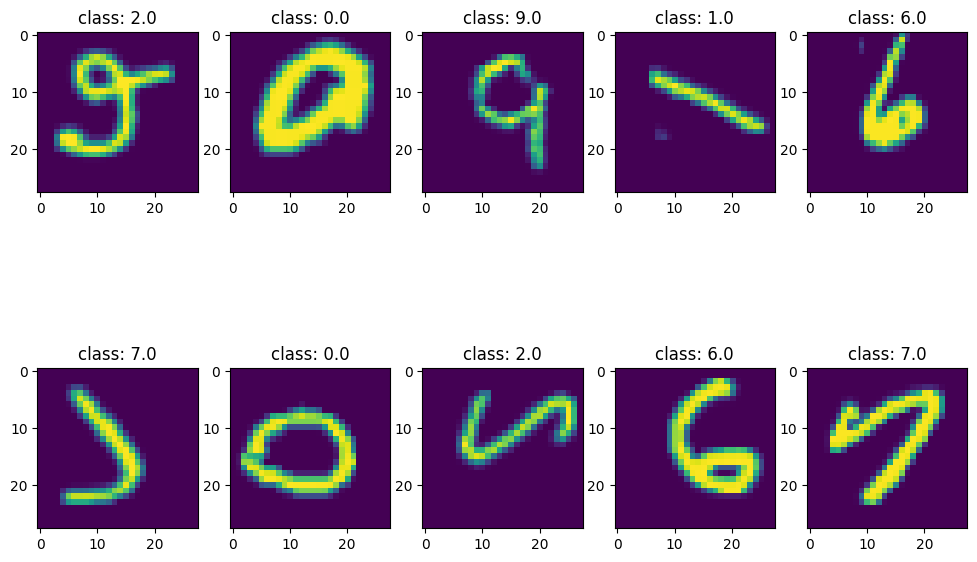

In [12]:
Plot(mnist_data, mnist_label)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.apply(init_weights)
model.to(device)


/home/student-1/notebooks/utils/PDOeConv.py:263: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


PDO_eConvs(
  (conv1): P8_PDO_Conv_Z2()
  (conv2): P8_PDO_Conv_P8()
  (conv3): P8_PDO_Conv_P8()
  (conv4): P8_PDO_Conv_P8()
  (conv5): P8_PDO_Conv_P8()
  (conv6): P8_PDO_Conv_P8()
  (dropout): Dropout(p=0.19, inplace=False)
  (bn1): BN_P8(
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn2): BN_P8(
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn3): BN_P8(
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn4): BN_P8(
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn5): BN_P8(
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn6): BN_P8(
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features

In [14]:
lr, num_epochs = 1e-4, 40
batch = 128
optimizer = optim.Adam(model.parameters(), lr=lr)

In [15]:
from utils.checkpoint import generate_output_dir, Logger
import os

2025-06-27 15:14:21.460287: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 15:14:21.484332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-27 15:14:22.006980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
out_dir = './training'
run_desc = 'PD0_4_6M'
run_dir = generate_output_dir(out_dir, run_desc)
# run_dir = './training/00006-PD0_4_6M'

In [17]:
with Logger(os.path.join(run_dir, 'Log.txt')):
    model, optim = train(model, train_loader, val_loader, batch, optimizer, num_epochs, device, evaluate_accuracy)
    

training on  cuda
/home/student-1/notebooks/utils/PDOeConv.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tran = [torch.tensor(a, dtype=torch.float32, device=device) for a in tran]
epoch 1, loss 2.3955, train acc 0.242, test acc 0.295, time 4.5 sec
epoch 2, loss 0.7881, train acc 0.468, test acc 0.530, time 4.3 sec
epoch 3, loss 0.3877, train acc 0.598, test acc 0.643, time 4.3 sec
epoch 4, loss 0.2226, train acc 0.695, test acc 0.716, time 4.3 sec
epoch 5, loss 0.1390, train acc 0.758, test acc 0.784, time 4.3 sec
epoch 6, loss 0.0970, train acc 0.802, test acc 0.767, time 4.3 sec
epoch 7, loss 0.0708, train acc 0.834, test acc 0.803, time 4.3 sec
epoch 8, loss 0.0524, train acc 0.860, test acc 0.836, time 4.3 sec
epoch 9, loss 0.0408, train acc 0.875, test acc 0.848, time 4.3 sec
epoch 10, loss 0.0318, train acc 0.897, test acc 

# Model Evaluation



In [18]:
# torch.save(model.state_dict(), 'PDO_4_6.pth')

In [19]:
all_preds = []
all_labels = []
total_correct = 0
total_samples = 0
max_batches = 391
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_loader):
        if batch_idx >= max_batches:
            break
        # print(f"Batch {batch_idx + 1}: Input shape: {data.shape}, Label shape: {label.shape}")
        data, label = data.cuda(), label.cuda()
        prediction = model(data)
        preds = prediction.argmax(dim=1)

        all_preds.append(preds.cuda())
        all_labels.append(label.cuda())

        correct = (preds == label).sum().item()
        total_correct += correct
        total_samples += data.size(0)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

In [20]:
accuracy = total_correct/total_samples

In [21]:
accuracy

0.9136

In [22]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    P8_PDO_Conv_Z2-1          [-1, 256, 26, 26]             288
       BatchNorm2d-2          [-1, 32, 208, 26]              64
             BN_P8-3          [-1, 256, 26, 26]               0
           Dropout-4          [-1, 256, 26, 26]               0
    P8_PDO_Conv_P8-5          [-1, 256, 24, 24]          73,728
       BatchNorm2d-6          [-1, 32, 192, 24]              64
             BN_P8-7          [-1, 256, 24, 24]               0
         MaxPool2d-8          [-1, 256, 12, 12]               0
    P8_PDO_Conv_P8-9          [-1, 256, 10, 10]          73,728
      BatchNorm2d-10           [-1, 32, 80, 10]              64
            BN_P8-11          [-1, 256, 10, 10]               0
          Dropout-12          [-1, 256, 10, 10]               0
   P8_PDO_Conv_P8-13            [-1, 256, 8, 8]          73,728
      BatchNorm2d-14            [-1, 32

In [23]:
# Model accuracy 94%


In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score

In [25]:
# log_path = 'training/00006-PD0_4_6M/Log.txt'

In [26]:
import re
log_data = []

with open(log_path, 'r')as f:
    log_data = f.readlines()

losses = []
train_acc = []
val_acc = []

for line in log_data:
    loss_match = re.search(r"loss (\d+\.\d+)", line)
    train_acc_match = re.search(r"train acc (\d+\.\d+)", line)
    val_acc_match = re.search(r"test acc (\d+\.\d+)", line)
    time_match
    
    if loss_match and train_acc_match and val_acc_match:
        losses.append(float(loss_match.group(1)))
        train_acc.append(float(train_acc_match.group(1)))
        val_acc.append(float(val_acc_match.group(1)))
    else:
        print("Skipping unmatched line:", line)
        


In [33]:
save_figs = '/home/student-1/notebooks'

In [28]:
# import os
# plt.plot(train_acc, losses, label='Train Acc')
# plt.plot(val_acc, losses, '--', label='Val Acc')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.savefig(os.path.join(save_figs, 'trainning_fig_46.png'))

In [29]:
CM = confusion_matrix(all_labels.cpu(), all_preds.cpu())

In [30]:
cm_display = ConfusionMatrixDisplay(CM)

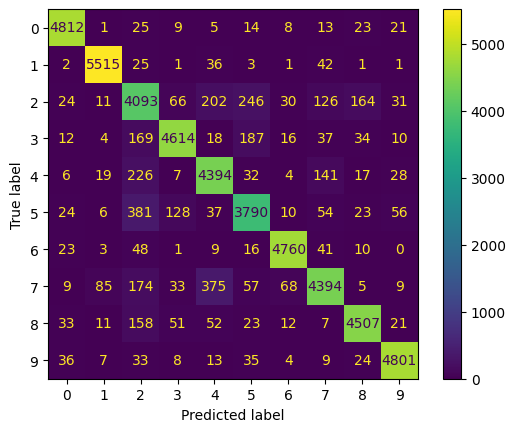

In [34]:
import os
cm_display.plot()
# plt.show()
plt.savefig(os.path.join(save_figs, 'CM46_new.png'))

In [ ]:
F1 = f1_score(all_labels.cpu(), all_preds.cpu(), average='macro')

In [ ]:
F1